# **Strain Gage Calculations - v1**

- All the required input files should be in the same directory as this notebook
- Output files will be in the same directory as well.

--------
### **Import Libraries**

In [183]:
# region

import pandas as pd
import numpy as np
import re
import plotly.express as px
from openpyxl import load_workbook
# import sys
# from PyQt5.QtWidgets import QApplication, QFileDialog

import plotly.graph_objs as go
from scipy.interpolate import interp1d
import ipywidgets as widgets
from IPython.display import display
import endaq

# endregion

------

### **Define Material Properties**

In [184]:
# Define the material properties and the strain gauge angles

E = 200e9  # Young's Modulus in Pascals (Pa)
v = 0.3  # Poisson's ratio

--------
### **Functions for Converting the Measured Rosette Strains into Various Outputs** 

References for the formulas used: 

https://community.sw.siemens.com/s/article/rosette-strain-gauges

https://www.youtube.com/watch?v=9x-3H74a8YQ

https://amesweb.info/Stress-Strain/Strain-Gauge-Rosette-Calculation-Example.aspx


In [185]:
def transform_strains_to_global(epsilon_A, epsilon_B, epsilon_C, angles):
    """
    Transform strains from the rosette's local coordinate system to the global coordinate system.

    Parameters:
    - epsilon_A (float): Measured normal strain from the first strain gauge in the rosette.
    - epsilon_B (float): Measured normal strain from the second strain gauge in the rosette.
    - epsilon_C (float): Measured normal strain from the third strain gauge in the rosette.
    - angles (list of float): The angles (in degrees) of the strain gauges relative to the global x-axis.

    Returns:
    - numpy.array: The transformed strains in the global coordinate system, containing
      the normal strains epsilon_x and epsilon_y, along with the engineering shear strain gamma_xy.
    """
    theta_A, theta_B, theta_C = np.radians(angles)
    T = np.array([
        [np.cos(theta_A)**2, np.sin(theta_A)**2, 1 * np.sin(theta_A) * np.cos(theta_A)],
        [np.cos(theta_B)**2, np.sin(theta_B)**2, 1 * np.sin(theta_B) * np.cos(theta_B)],
        [np.cos(theta_C)**2, np.sin(theta_C)**2, 1 * np.sin(theta_C) * np.cos(theta_C)]
    ])
    T_inv = np.linalg.inv(T)
    local_strains = np.array([epsilon_A, epsilon_B, epsilon_C])
    global_strains = T_inv @ local_strains
    return global_strains

def calculate_principal_strains(epsilon_x, epsilon_y, gamma_xy):
    """
    Calculate the principal strains using Mohr's circle relations.

    Parameters:
    - epsilon_x (float): Normal strain in the x-direction (global coordinate system).
    - epsilon_y (float): Normal strain in the y-direction (global coordinate system).
    - gamma_xy (float): Engineering shear strain in the global coordinate system.

    Returns:
    - numpy.array: An array containing the maximum (epsilon_1) and minimum (epsilon_2)
      principal strains. These values are critical for assessing the material's behavior
      under stress and for failure analysis.

    Note:
    - The shear strain input should be in engineering terms (total angular deformation),
      as this is the standard output from strain gauges.
    """
    C = (epsilon_x + epsilon_y) / 2
    R = np.sqrt(((epsilon_x - epsilon_y) / 2)**2 + (gamma_xy / 2)**2)
    epsilon_1 = C + R  # Maximum principal strain
    epsilon_2 = C - R  # Minimum principal strain
    return np.array([epsilon_1, epsilon_2])

def calculate_principal_stresses(principal_strains, E, v):
    """
    Calculate the principal stresses from the principal strains using material properties.

    Given the principal strains, this function applies Hooke's law in two dimensions to
    compute the principal stresses. The material's Young's modulus (E) and Poisson's ratio (v)
    are used to relate the strains to the stresses. This function assumes a linear elastic
    material behavior and plane stress conditions, which is a common scenario in thin structures
    where one dimension is significantly smaller than the other two.

    Parameters:
    - principal_strains (numpy.array): An array of the principal strains [epsilon_1, epsilon_2].
    - E (float): Young's Modulus of the material in Pascals (Pa).
    - v (float): Poisson's ratio of the material, dimensionless.

    Returns:
    - numpy.array: An array containing the principal stresses [sigma_1, sigma_2] in Pascals (Pa).
      These stresses are the maximum and minimum normal stresses that occur at the principal
      strain orientations, where the shear stress is zero.

    Note:
    - The principal strains should be provided in microstrains (με) for the calculation.
    - The function returns the principal stresses in Pascals (Pa), but they are manually
      converted to other MPa (MegaPascals) at the function return (by a /1e6 division).
    - The function holds true for isotropic materials where the stress-strain relationship 
      is governed by the isotropic form of Hooke's law.
    """
    #S = np.array([
    #    [1, v, 0],
    #    [v, 1, 0],
    #    [0, 0, (1-v)/2]
    #]) * E / (1 - v**2)
    S = np.array([
        [1, v],
        [v, 1]
    ]) * E / (1 - v**2)

    principal_stresses = S @ (principal_strains /1e6)
    return principal_stresses / 1e6  # Convert Pa to MPa

def calculate_principal_strain_orientation(epsilon_x, epsilon_y, gamma_xy):
    """
    Calculate the orientation of the principal strains from the original strain measurements using Mohr's circle analysis.
    Parameters:
    - epsilon_x (float): Normal strain in the x-direction.
    - epsilon_y (float): Normal strain in the y-direction.
    - gamma_xy (float): Engineering shear strain.
    Returns:
    - theta_p (float): Angle of the principal strain in degrees.
    """
    # Calculate the angle to the maximum principal strain
    theta_p_rad = 0.5 * np.arctan2(gamma_xy, epsilon_x - epsilon_y)
    theta_p = np.degrees(theta_p_rad)

    # Adjust the angle to ensure it's within the 0-180 degree range
    if theta_p < 0:
        theta_p += 180

    return theta_p

def calculate_biaxiality_ratio(S1, S2):
    """
    Calculate the biaxiality ratio from the principal stresses.

    The biaxiality ratio is the ratio of the second principal stress to the first principal stress.
    It is a dimensionless number that indicates the relation between the principal stresses. A
    biaxiality ratio of 1 indicates equal biaxial stress state, while a value of 0 indicates a uniaxial
    stress state. Negative values indicate that the principal stresses are of opposite signs.

    Parameters:
    - S1 (float or numpy.array): First principal stress (assumed to be the larger one in absolute value).
    - S2 (float or numpy.array): Second principal stress (assumed to be the smaller one in absolute value).

    Returns:
    - float or numpy.array: The biaxiality ratio, a dimensionless quantity indicating the biaxial state of stress.

    Note:
    - The function assumes that S1 and S2 are provided such that the absolute value of S1 is
      greater than or equal to the absolute value of S2. If this is not the case, the inputs
      should be swapped.
    """
    # Ensure that sigma_1 is the larger one in absolute terms
    sigma_1 = np.where(np.abs(S1) >= np.abs(S2), S1, S2)
    sigma_2 = np.where(np.abs(S1) >= np.abs(S2), S2, S1)
    
    # Calculate the biaxiality ratio
    biaxiality_ratio = sigma_2 / sigma_1
    
    return biaxiality_ratio

def calculate_von_mises_stress(S1, S2, S3=0):
    """
    Calculate the von Mises stress from the principal stresses.
    
    Parameters:
    S1 (float): First principal stress in MPa.
    S2 (float): Second principal stress in MPa.
    S3 (float): Third principal stress in MPa, assumed to be zero for plane stress condition.
    
    Returns:
    float: The von Mises stress in MPa.
    """
    # Calculate the von Mises stress using the principal stresses
    sigma_vm = np.sqrt(((S1 - S2)**2 + (S1 - S3)**2 + (S2 - S3)**2) / 2)
    return sigma_vm


-------

### **Load Input Files**

>**"Name of any FEA data file here".csv**
* Specifies the input CSV data for FEA

    - First column should be time in seconds
    
    - Remaining columns are strains in each rosette channel, __(units are in [μmm/mm])__

    - Example format:

        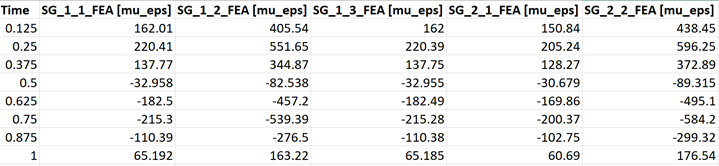
    

>**"Name of any test data file here".csv**
* Specifies the input CSV data for FEA

    - First column should be time in seconds
    
    - Remaining columns are strains in each rosette channel, __(units are in [μmm/mm])__

    - Example format:

        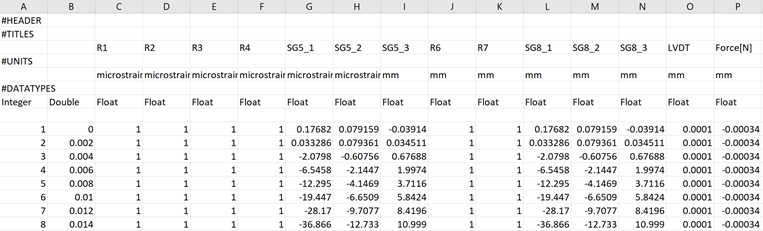


>**"Name of SG vs. rosette angle [°] file here".csv**
* Specifies the angles of each channel of a rosette with respect to their preferred axis

    - First column should be the channel name of rosette (SG1_1, SG2 etc.)

    - Remaining columns should be angles in degrees wrt to preferred axis

    - Example format:

        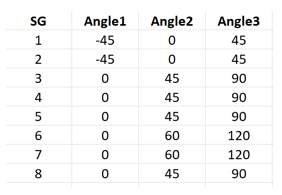

    

In [186]:
# Selecting the files through a dialog box
# region




# import sys
# from PyQt5.QtWidgets import QApplication, QFileDialog

# # Initialize the application
# app = QApplication(sys.argv)

# # File selection for FEA data
# file_path, _ = QFileDialog().getOpenFileName(None, 'Open FEA raw data file for SG rosettes', '', 'All Files (*);;CSV Files (*.csv)')

# # Check if a file was selected for FEA data
# if file_path:
#     print("Selected FEA data:", file_path)
# else:
#     print("No FEA data file selected.")
#     # Handle the case when no file is selected, or set file_path to a default value
#     # file_path = 'default_FEA_data.csv'


# # File selection for raw test data of strain gauge rosettes
# file_path_measured, _ = QFileDialog().getOpenFileName(None, 'Open test raw data file for SG rosettes', '', 'All Files (*);;CSV Files (*.csv)')

# # Check if a file was selected for test data
# if file_path_measured:
#     print("Selected test data:", file_path_measured)
# else:
#     print("No test data file selected.")
#     # Handle the case when no file is selected, or set file_path to a default value
#     # file_path = 'default_test_data.csv'


# # File selection for rosette angles data
# angles_file_path, _ = QFileDialog().getOpenFileName(None, 'Open File', '', 'All Files (*);;CSV Files (*.csv)')

# # Check if a file was selected for rosette angles data
# if angles_file_path:
#     print("Selected rosette angles data:", angles_file_path)
# else:
#     print("No rosette angles data file selected.")
#     # Handle the case when no file is selected, or set angles_file_path to a default value
#     # angles_file_path = 'default_angles_data.csv'



# endregion

---
##### **Assign rosette configurations/angles**

In [187]:
# Load the CSV file containing the rosette angles
# region
angles_file_path = 'rosette_angles_v2.csv'
rosette_angles_df = pd.read_csv(angles_file_path)
print("Selected rosette angles data:", angles_file_path)
# endregion

Selected rosette angles data: rosette_angles_v2.csv


---
##### **Read SG results from FEA**

In [188]:
# Load the CSV file extracted from FEA, using "Strain Gage Toolbox" inside ANSYS Mechanical
# region

file_path_FEA = 'SG_sample_out_data_sg_filtered_v3_long_test.csv'
data = pd.read_csv(file_path_FEA)

print("Selected FEA output data from directory:   ", file_path_FEA)

time = data['Time']
strain_gauge_data_FEA = data.iloc[:, 1:].filter(regex='SG')
strain_gauge_data_FEA.reset_index(drop=True, inplace=True)
time.reset_index(drop=True, inplace=True)
strain_gauge_data_FEA
# endregion

Selected FEA output data from directory:    SG_sample_out_data_sg_filtered_v3_long_test.csv


,SG5_1,SG5_2,SG5_3,SG8_1,SG8_2,SG8_3
0,0.176820,0.079159,-0.039136,0.176820,0.079159,-0.039136
1,0.033286,0.079361,0.034511,0.033286,0.079361,0.034511
2,-2.079800,-0.607560,0.676880,-2.079800,-0.607560,0.676880
3,-6.545800,-2.144700,1.997400,-6.545800,-2.144700,1.997400
4,-12.295000,-4.146900,3.711600,-12.295000,-4.146900,3.711600
...,...,...,...,...,...,...
1495,71.656000,25.646000,-21.586000,71.656000,25.646000,-21.586000
1496,52.097000,18.646000,-15.694000,52.097000,18.646000,-15.694000
1497,32.297000,11.559000,-9.729000,32.297000,11.559000,-9.729000
1498,12.348000,4.419000,-3.719000,12.348000,4.419000,-3.719000


---
##### **Read SG results from Test**

In [189]:
# Load the CSV file extracted from test, using "Strain Gage Toolbox" inside ANSYS Mechanical
# region
file_path_measured = 'SG_sample_out_data_raw_format.csv'
data = pd.read_csv(file_path_measured)

if "_raw_format" in file_path_measured:
    data.drop([0,2,3,4,5,6], inplace=True)
    data.columns=data.iloc[0]
    new_columns = data.columns.tolist()
    new_columns[1] = 'Time'
    data.columns = new_columns
    data.drop([1], inplace=True)
    data.drop(data.columns[0], axis=1, inplace=True)
    print("Selected test data from directory:   ", file_path_measured)
else:
    print("The input file is not read. Check whether it is in the correct directory or has the correct file name convention, with '_raw_data' suffix ")
    exit()

time = data['Time']
strain_gauge_data_measured = data.iloc[:, 1:].filter(regex='SG')
strain_gauge_data_measured.reset_index(drop=True, inplace=True)
time.reset_index(drop=True, inplace=True)
strain_gauge_data_measured
# endregion

Selected test data from directory:    SG_sample_out_data_raw_format.csv


,SG5_1,SG5_2,SG5_3,SG8_1,SG8_2,SG8_3
0,0.17682,0.079159,-0.039136,0.17682,0.079159,-0.039136
1,0.033286,0.079361,0.034511,0.033286,0.079361,0.034511
2,-2.0798,-0.60756,0.67688,-2.0798,-0.60756,0.67688
3,-6.5458,-2.1447,1.9974,-6.5458,-2.1447,1.9974
4,-12.295,-4.1469,3.7116,-12.295,-4.1469,3.7116
...,...,...,...,...,...,...
1495,71.656,25.646,-21.586,71.656,25.646,-21.586
1496,52.097,18.646,-15.694,52.097,18.646,-15.694
1497,32.297,11.559,-9.729,32.297,11.559,-9.729
1498,12.348,4.419,-3.719,12.348,4.419,-3.719


---
### **Calculations**

* The main function for the calculation of all variables is defined here:

In [190]:
# region

def calculate_all_SG_variables(strain_gauge_data, rosette_angles_df):

    # Get a list of column names that match the pattern 'SG(\d+)_'
    matching_columns = [col for col in strain_gauge_data.columns if re.search(r'SG(\d+)_', col)]
    # Extract the numerical part from the matching column names
    sg_numbers = [int(re.search(r'SG(\d+)_', col).group(1)) for col in matching_columns]
    # Remove duplicates and sort the extracted numerical values
    sg_numbers = sorted(set(sg_numbers))

    for sg_number in sg_numbers:
        sg_cols = [col for col in strain_gauge_data.columns if f'SG{sg_number}_' in col]

        # Ensure there are three columns per strain gauge
        if len(sg_cols) == 3:
            rosette_row = rosette_angles_df[rosette_angles_df['SG'] == sg_number]
            if not rosette_row.empty:
                current_angles = rosette_row.iloc[0, 1:].values
                strains = strain_gauge_data[sg_cols].values.astype(dtype=np.float64)
                global_strains = np.array([transform_strains_to_global(*strain, current_angles) for strain in strains])
                principal_strains = np.array([calculate_principal_strains(strain[0], strain[1], strain[2]) for strain in global_strains])
                principal_stresses = np.array([calculate_principal_stresses(strain, E, v) for strain in principal_strains])
                principal_strain_orientation = np.array([calculate_principal_strain_orientation(strain[0], strain[1], strain[2]) for strain in global_strains])
                biaxiality_ratios = calculate_biaxiality_ratio(principal_stresses[:, 0], principal_stresses[:, 1])
                von_mises_stresses = np.array([calculate_von_mises_stress(*stress) for stress in principal_stresses])
                for i, strain_type in enumerate(['epsilon_x [με]', 'epsilon_y [με]', 'gamma_xy [με]']):
                    strain_gauge_data[f'SG{sg_number}_{strain_type}'] = global_strains[:, i]
                strain_gauge_data[f'SG{sg_number}_sigma_1 [MPa]'], strain_gauge_data[f'SG{sg_number}_sigma_2 [MPa]'] = principal_stresses.T
                strain_gauge_data[f'SG{sg_number}_theta_p [°]'] = principal_strain_orientation
                strain_gauge_data[f'SG{sg_number}_Biaxiality_Ratio'] = biaxiality_ratios
                strain_gauge_data[f'SG{sg_number}_von_Mises [MPa]'] = von_mises_stresses
            else:
                print(f'Angles for Rosette {sg_number} not found in angles file.')
        else:
            print(f'Unexpected number of columns for Rosette {sg_number}.')

    return strain_gauge_data

# endregion


#### **1)** Output: FEA

In [191]:
time=time.astype(float)

In [192]:
# region
strain_gauge_data_FEA = calculate_all_SG_variables(strain_gauge_data_FEA, rosette_angles_df)
strain_gauge_data_FEA.insert(0, 'Time', time)
strain_gauge_data_FEA
# endregion

,Time,SG5_1,SG5_2,SG5_3,SG8_1,SG8_2,SG8_3,SG5_epsilon_x [με],SG5_epsilon_y [με],SG5_gamma_xy [με],...,SG5_Biaxiality_Ratio,SG5_von_Mises [MPa],SG8_epsilon_x [με],SG8_epsilon_y [με],SG8_gamma_xy [με],SG8_sigma_1 [MPa],SG8_sigma_2 [MPa],SG8_theta_p [°],SG8_Biaxiality_Ratio,SG8_von_Mises [MPa]
0,0.000,0.176820,0.079159,-0.039136,0.176820,0.079159,-0.039136,0.176820,-0.039136,0.020634,...,0.082006,0.034962,0.079159,0.058525,-0.215956,0.036357,0.002981,137.728943,0.082006,0.034962
1,0.002,0.033286,0.079361,0.034511,0.033286,0.079361,0.034511,0.033286,0.034511,0.090925,...,0.161295,0.015511,0.079361,-0.011564,0.001225,0.016680,0.002690,0.385939,0.161295,0.015511
2,0.004,-2.079800,-0.607560,0.676880,-2.079800,-0.607560,0.676880,-2.079800,0.676880,0.187800,...,-0.029365,0.419156,-0.607560,-0.795360,2.756680,0.012127,-0.412961,43.051361,-0.029365,0.419156
3,0.006,-6.545800,-2.144700,1.997400,-6.545800,-2.144700,1.997400,-6.545800,1.997400,0.259000,...,-0.005890,1.311109,-2.144700,-2.403700,8.543200,0.007700,-1.307243,44.131762,-0.005890,1.311109
4,0.008,-12.295000,-4.146900,3.711600,-12.295000,-4.146900,3.711600,-12.295000,3.711600,0.289600,...,-0.002148,2.460322,-4.146900,-4.436500,16.006600,0.005278,-2.457678,44.481744,-0.002148,2.460322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,2.990,71.656000,25.646000,-21.586000,71.656000,25.646000,-21.586000,71.656000,-21.586000,1.222000,...,-0.001411,14.336055,25.646000,24.424000,-93.242000,14.325935,-0.020220,135.375429,-0.001411,14.336055
1496,2.992,52.097000,18.646000,-15.694000,52.097000,18.646000,-15.694000,52.097000,-15.694000,0.889000,...,-0.001413,10.422933,18.646000,17.757000,-67.791000,10.415569,-0.014712,135.375662,-0.001413,10.422933
1497,2.994,32.297000,11.559000,-9.729000,32.297000,11.559000,-9.729000,32.297000,-9.729000,0.550000,...,-0.001401,6.461574,11.559000,11.009000,-42.026000,6.457046,-0.009046,135.374897,-0.001401,6.461574
1498,2.996,12.348000,4.419000,-3.719000,12.348000,4.419000,-3.719000,12.348000,-3.719000,0.209000,...,-0.001342,2.470400,4.419000,4.210000,-16.067000,2.468742,-0.003313,135.372632,-0.001342,2.470400



#### **2)** Output: Test

In [193]:
# region
strain_gauge_data_measured= calculate_all_SG_variables(strain_gauge_data_measured, rosette_angles_df)
strain_gauge_data_measured.insert(0, 'Time', time)
strain_gauge_data_measured
# endregion

,Time,SG5_1,SG5_2,SG5_3,SG8_1,SG8_2,SG8_3,SG5_epsilon_x [με],SG5_epsilon_y [με],SG5_gamma_xy [με],...,SG5_Biaxiality_Ratio,SG5_von_Mises [MPa],SG8_epsilon_x [με],SG8_epsilon_y [με],SG8_gamma_xy [με],SG8_sigma_1 [MPa],SG8_sigma_2 [MPa],SG8_theta_p [°],SG8_Biaxiality_Ratio,SG8_von_Mises [MPa]
0,0.000,0.17682,0.079159,-0.039136,0.17682,0.079159,-0.039136,0.176820,-0.039136,0.020634,...,0.082006,0.034962,0.079159,0.058525,-0.215956,0.036357,0.002981,137.728943,0.082006,0.034962
1,0.002,0.033286,0.079361,0.034511,0.033286,0.079361,0.034511,0.033286,0.034511,0.090925,...,0.161295,0.015511,0.079361,-0.011564,0.001225,0.016680,0.002690,0.385939,0.161295,0.015511
2,0.004,-2.0798,-0.60756,0.67688,-2.0798,-0.60756,0.67688,-2.079800,0.676880,0.187800,...,-0.029365,0.419156,-0.607560,-0.795360,2.756680,0.012127,-0.412961,43.051361,-0.029365,0.419156
3,0.006,-6.5458,-2.1447,1.9974,-6.5458,-2.1447,1.9974,-6.545800,1.997400,0.259000,...,-0.005890,1.311109,-2.144700,-2.403700,8.543200,0.007700,-1.307243,44.131762,-0.005890,1.311109
4,0.008,-12.295,-4.1469,3.7116,-12.295,-4.1469,3.7116,-12.295000,3.711600,0.289600,...,-0.002148,2.460322,-4.146900,-4.436500,16.006600,0.005278,-2.457678,44.481744,-0.002148,2.460322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,2.990,71.656,25.646,-21.586,71.656,25.646,-21.586,71.656000,-21.586000,1.222000,...,-0.001411,14.336055,25.646000,24.424000,-93.242000,14.325935,-0.020220,135.375429,-0.001411,14.336055
1496,2.992,52.097,18.646,-15.694,52.097,18.646,-15.694,52.097000,-15.694000,0.889000,...,-0.001413,10.422933,18.646000,17.757000,-67.791000,10.415569,-0.014712,135.375662,-0.001413,10.422933
1497,2.994,32.297,11.559,-9.729,32.297,11.559,-9.729,32.297000,-9.729000,0.550000,...,-0.001401,6.461574,11.559000,11.009000,-42.026000,6.457046,-0.009046,135.374897,-0.001401,6.461574
1498,2.996,12.348,4.419,-3.719,12.348,4.419,-3.719,12.348000,-3.719000,0.209000,...,-0.001342,2.470400,4.419000,4.210000,-16.067000,2.468742,-0.003313,135.372632,-0.001342,2.470400


----
### **Create Excel files**

In [194]:
# Function for generating an excel file from strain gauge output dataframe, where only von_Mises results are shown but the rest of all other data is hidden:
# region

def create_excel_from_strain_gauge_data(strain_gauge_data, input_file_path):
    #strain_gauge_data.insert(0, 'Time', time)
    excel_file_path = str(input_file_path) + "_results.xlsx"
    strain_gauge_data.to_excel(excel_file_path, index=False)
    wb = load_workbook(excel_file_path)
    ws = wb.active
    columns_to_hide = [col for col in ws.columns if col[0].value is not None and 'von_Mises' not in col[0].value and col[0].value != 'Time']
    for column in columns_to_hide:
        ws.column_dimensions[column[0].column_letter].hidden = True
    wb.save(excel_file_path)

    # Checking the data inside the output excel
    for column in ws.columns:
        #print(f"Header: {column[0].value}, Column: {column[0].column_letter}")
        print(f"{column[0].value}")
    strain_gauge_data

# endregion

#### **1)** Output: FEA

In [195]:
# region
create_excel_from_strain_gauge_data(strain_gauge_data_FEA, file_path_FEA)
# endregion

Time
SG5_1
SG5_2
SG5_3
SG8_1
SG8_2
SG8_3
SG5_epsilon_x [με]
SG5_epsilon_y [με]
SG5_gamma_xy [με]
SG5_sigma_1 [MPa]
SG5_sigma_2 [MPa]
SG5_theta_p [°]
SG5_Biaxiality_Ratio
SG5_von_Mises [MPa]
SG8_epsilon_x [με]
SG8_epsilon_y [με]
SG8_gamma_xy [με]
SG8_sigma_1 [MPa]
SG8_sigma_2 [MPa]
SG8_theta_p [°]
SG8_Biaxiality_Ratio
SG8_von_Mises [MPa]


#### **1)** Output: Test

In [196]:
# region
create_excel_from_strain_gauge_data(strain_gauge_data_measured, file_path_measured)
# endregion

Time
SG5_1
SG5_2
SG5_3
SG8_1
SG8_2
SG8_3
SG5_epsilon_x [με]
SG5_epsilon_y [με]
SG5_gamma_xy [με]
SG5_sigma_1 [MPa]
SG5_sigma_2 [MPa]
SG5_theta_p [°]
SG5_Biaxiality_Ratio
SG5_von_Mises [MPa]
SG8_epsilon_x [με]
SG8_epsilon_y [με]
SG8_gamma_xy [με]
SG8_sigma_1 [MPa]
SG8_sigma_2 [MPa]
SG8_theta_p [°]
SG8_Biaxiality_Ratio
SG8_von_Mises [MPa]


In [197]:
strain_gauge_data_measured

,Time,SG5_1,SG5_2,SG5_3,SG8_1,SG8_2,SG8_3,SG5_epsilon_x [με],SG5_epsilon_y [με],SG5_gamma_xy [με],...,SG5_Biaxiality_Ratio,SG5_von_Mises [MPa],SG8_epsilon_x [με],SG8_epsilon_y [με],SG8_gamma_xy [με],SG8_sigma_1 [MPa],SG8_sigma_2 [MPa],SG8_theta_p [°],SG8_Biaxiality_Ratio,SG8_von_Mises [MPa]
0,0.000,0.17682,0.079159,-0.039136,0.17682,0.079159,-0.039136,0.176820,-0.039136,0.020634,...,0.082006,0.034962,0.079159,0.058525,-0.215956,0.036357,0.002981,137.728943,0.082006,0.034962
1,0.002,0.033286,0.079361,0.034511,0.033286,0.079361,0.034511,0.033286,0.034511,0.090925,...,0.161295,0.015511,0.079361,-0.011564,0.001225,0.016680,0.002690,0.385939,0.161295,0.015511
2,0.004,-2.0798,-0.60756,0.67688,-2.0798,-0.60756,0.67688,-2.079800,0.676880,0.187800,...,-0.029365,0.419156,-0.607560,-0.795360,2.756680,0.012127,-0.412961,43.051361,-0.029365,0.419156
3,0.006,-6.5458,-2.1447,1.9974,-6.5458,-2.1447,1.9974,-6.545800,1.997400,0.259000,...,-0.005890,1.311109,-2.144700,-2.403700,8.543200,0.007700,-1.307243,44.131762,-0.005890,1.311109
4,0.008,-12.295,-4.1469,3.7116,-12.295,-4.1469,3.7116,-12.295000,3.711600,0.289600,...,-0.002148,2.460322,-4.146900,-4.436500,16.006600,0.005278,-2.457678,44.481744,-0.002148,2.460322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,2.990,71.656,25.646,-21.586,71.656,25.646,-21.586,71.656000,-21.586000,1.222000,...,-0.001411,14.336055,25.646000,24.424000,-93.242000,14.325935,-0.020220,135.375429,-0.001411,14.336055
1496,2.992,52.097,18.646,-15.694,52.097,18.646,-15.694,52.097000,-15.694000,0.889000,...,-0.001413,10.422933,18.646000,17.757000,-67.791000,10.415569,-0.014712,135.375662,-0.001413,10.422933
1497,2.994,32.297,11.559,-9.729,32.297,11.559,-9.729,32.297000,-9.729000,0.550000,...,-0.001401,6.461574,11.559000,11.009000,-42.026000,6.457046,-0.009046,135.374897,-0.001401,6.461574
1498,2.996,12.348,4.419,-3.719,12.348,4.419,-3.719,12.348000,-3.719000,0.209000,...,-0.001342,2.470400,4.419000,4.210000,-16.067000,2.468742,-0.003313,135.372632,-0.001342,2.470400


In [198]:
# region
# Use whichever data is available for extraction, since their headers should already be identical
if not strain_gauge_data_FEA.empty:
    headers_strain_gauge_data_FEA = strain_gauge_data_FEA.columns.tolist()

elif not strain_gauge_data_measured.empty:
    headers_strain_gauge_data_measured = strain_gauge_data_FEA.columns.tolist()


# Define the function
def extract_SG_names_channels_names_and_data_types(sensor_data):
    # Initializing lists for sensor names, channel names, and a dictionary for unique data types
    list_SG_sensor_names = set()
    list_SG_channel_names = []
    unique_data_types = {}  # Using a dictionary to preserve order and uniqueness

    # Iterate through the list and classify the elements
    for item in sensor_data:
        parts = item.split("_")
        sensor_name = parts[0]
        
        # Filter out sensor names that don't start with "SG"
        if sensor_name.startswith("SG"):
            list_SG_sensor_names.add(sensor_name)

            if len(parts) > 1:
                # Check if the part after the first "_" is a number
                if parts[1].isdigit():
                    list_SG_channel_names.append(item)
                else:
                    # Remove sensor name part for data types and store in dictionary
                    data_type = "_".join(parts[1:])
                    unique_data_types[data_type] = None  # Value is not important

    # Convert sets and dictionaries to lists
    list_SG_sensor_names = list(list_SG_sensor_names)
    list_SG_data_types = list(unique_data_types.keys())

    return list_SG_sensor_names, list_SG_data_types, list_SG_channel_names


# Call the function and its output lists, which will then be used in dropdowns menus later
if not strain_gauge_data_FEA.empty:
    list_SG_sensor_names, list_SG_data_types, list_SG_channel_names = \
        extract_SG_names_channels_names_and_data_types(headers_strain_gauge_data_FEA)
    
elif not strain_gauge_data_measured.empty:
    list_SG_sensor_names, list_SG_data_types, list_SG_channel_names = \
        extract_SG_names_channels_names_and_data_types(headers_strain_gauge_data_measured)

# Display the saved variables
list_SG_sensor_names, list_SG_data_types

#endregion

(['SG8', 'SG5'],
 ['epsilon_x [με]',
  'epsilon_y [με]',
  'gamma_xy [με]',
  'sigma_1 [MPa]',
  'sigma_2 [MPa]',
  'theta_p [°]',
  'Biaxiality_Ratio',
  'von_Mises [MPa]'])

---
### **Comparison between measurements & FEA**

#### **1)** Extract SG numbers and data types

In [199]:
# region
# Use whichever data is available for extraction, since their headers should already be identical
if not strain_gauge_data_FEA.empty:
    headers_strain_gauge_data_FEA = strain_gauge_data_FEA.columns.tolist()

elif not strain_gauge_data_measured.empty:
    headers_strain_gauge_data_measured = strain_gauge_data_FEA.columns.tolist()


# Define the function
def extract_SG_names_channels_names_and_data_types(sensor_data):
    # Initializing lists for sensor names, channel names, and a dictionary for unique data types
    list_SG_sensor_names = set()
    list_SG_channel_names = []
    unique_data_types = {}  # Using a dictionary to preserve order and uniqueness

    # Iterate through the list and classify the elements
    for item in sensor_data:
        parts = item.split("_")
        sensor_name = parts[0]
        
        # Filter out sensor names that don't start with "SG"
        if sensor_name.startswith("SG"):
            list_SG_sensor_names.add(sensor_name)

            if len(parts) > 1:
                # Check if the part after the first "_" is a number
                if parts[1].isdigit():
                    list_SG_channel_names.append(item)
                else:
                    # Remove sensor name part for data types and store in dictionary
                    data_type = "_".join(parts[1:])
                    unique_data_types[data_type] = None 

    # Convert sets and dictionaries to lists
    list_SG_sensor_names = list(list_SG_sensor_names)
    list_SG_data_types = list(unique_data_types.keys())

    return list_SG_sensor_names, list_SG_data_types, list_SG_channel_names


# Call the function and its output lists, which will then be used in dropdowns menus later
if not strain_gauge_data_FEA.empty:
    list_SG_sensor_names, list_SG_data_types, list_SG_channel_names = \
        extract_SG_names_channels_names_and_data_types(headers_strain_gauge_data_FEA)
    
elif not strain_gauge_data_measured.empty:
    list_SG_sensor_names, list_SG_data_types, list_SG_channel_names = \
        extract_SG_names_channels_names_and_data_types(headers_strain_gauge_data_measured)

# Display the saved variables
list_SG_sensor_names, list_SG_data_types

#endregion

(['SG8', 'SG5'],
 ['epsilon_x [με]',
  'epsilon_y [με]',
  'gamma_xy [με]',
  'sigma_1 [MPa]',
  'sigma_2 [MPa]',
  'theta_p [°]',
  'Biaxiality_Ratio',
  'von_Mises [MPa]'])

In [200]:
# Plotting the data
# region

#endaq.plot.utilities.set_theme(theme='endaq')

# Generate a pure sine wave as one dataset and offset it
x1 = np.linspace(0, 10, 100)
y1 = np.sin(x1) + 1.5

# Generate a slightly randomized sine wave as the other dataset and offset it
x2 = np.linspace(0, 10, 50)
y2 = np.sin(x2) + np.random.normal(0, 0.1, 50) + 1.5

# Create interpolation functions for both datasets
interp_func1 = interp1d(x1, y1, kind='linear', fill_value='extrapolate')
interp_func2 = interp1d(x2, y2, kind='linear', fill_value='extrapolate')

# Create a common set of x values for comparison
common_x = x1

# Calculate the interpolated y values for both datasets
interpolated_y1 = interp_func1(common_x)
interpolated_y2 = interp_func2(common_x)

# Calculate the relative error as a percentage
relative_error_percent = ((interpolated_y2 - interpolated_y1) / interpolated_y1) * 100

# Calculate the difference between the offset sine waves
difference = interpolated_y1 - interpolated_y2

# Initialize the plot as a FigureWidget with subplots
fig = go.FigureWidget(
    data=[
        go.Scatter(x=common_x, y=interpolated_y1, mode='lines', name='y1_Interpolated ', xaxis='x1', yaxis='y1'),
        go.Scatter(x=common_x, y=interpolated_y2, mode='lines', name='y2_Interpolated ', xaxis='x1', yaxis='y1'),
        go.Scatter(x=common_x, y=relative_error_percent, mode='lines', name='Error (%)', xaxis='x2', yaxis='y2'),
        go.Scatter(x=common_x, y=difference, mode='lines', name='Δy', xaxis='x3', yaxis='y3')
    ],
    layout=go.Layout(
        #title="Comparison Between Datasets",
        height=800,  # Initial height
        xaxis=dict(domain=[0, 1], anchor='y1'),
        yaxis=dict(domain=[0.68, 1], title='y'),  # Adjust domain for spacing
        xaxis2=dict(domain=[0, 1], anchor='y2', matches='x1'),
        yaxis2=dict(domain=[0.36, 0.64], title='Error(%)'),  # Adjust domain for spacing
        xaxis3=dict(domain=[0, 1], anchor='y3', matches='x1'),
        yaxis3=dict(domain=[0, 0.32], title='Δy'),  # Adjust domain for spacing
        showlegend=True
    )
)
fig.update_layout(
    margin = dict(l=10, r=10, t=10, b=10)
)

def create_dimension_sliders(fig, initial_height=300, min_height=100, max_height=500, height_step=10,
                             initial_width=800, min_width=300, max_width=1500, width_step=10):
    """
    Create and display sliders to control the dimensions (height and width) of a Plotly figure.

    Parameters:
    - fig: The figure object to which the dimension sliders will be linked.
    - initial_height: The initial height of the figure.
    - min_height: The minimum height of the figure.
    - max_height: The maximum height of the figure.
    - height_step: The step size for the height adjustment.
    - initial_width: The initial width of the figure.
    - min_width: The minimum width of the figure.
    - max_width: The maximum width of the figure.
    - width_step: The step size for the width adjustment.
    """
    # Function to update the height of the plot
    def update_height(height):
        fig.layout.height = height

    # Function to update the width of the plot
    def update_width(width):
        fig.layout.width = width

    # Function to handle height change
    def on_height_change(change):
        update_height(change.new)

    # Function to handle width change
    def on_width_change(change):
        update_width(change.new)

    # Create a slider widget for total_height
    height_slider = widgets.IntSlider(
        value=initial_height, 
        min=min_height, 
        max=max_height, 
        step=height_step, 
        description='Figure Height'
    )
    
    # Create a slider widget for total_width
    width_slider = widgets.IntSlider(
        value=initial_width, 
        min=min_width, 
        max=max_width, 
        step=width_step, 
        description='Figure Width'
    )
    
    # Bring sliders together
    hbox_figure_size = widgets.HBox([height_slider,width_slider])
    hbox_layout = widgets.Layout(
        display = 'flex',
        flex_flow = 'column',
        #align_items = 'center',
        width = '100%',
        margin = 'auto'
    )
    hbox_figure_size.layout = hbox_layout


    # Display the sliders and the plot
    display(hbox_figure_size)

    # Add an observer to the slider to update the plot height and width
    height_slider.observe(on_height_change, names='value')
    width_slider.observe(on_width_change, names='value')

def create_dropdown_menus_for_selecting_SG_no_and_data_type(list_SG_sensor_names, list_SG_data_types):
        # Add dropdown menu to be able to select datasets for individual sensors
    dropdown_sensor_number = widgets.Dropdown(options=list_SG_sensor_names)
    dropdown_sensor_data_type = widgets.Dropdown(options=list_SG_data_types)


    # Bring sliders together
    vbox_sensor_name_and_data_type = widgets.VBox([dropdown_sensor_number,dropdown_sensor_data_type])
    vbox_layout = widgets.Layout(
        display = 'flex',
        flex_flow = 'column',
        #align_items = 'center',
        #justify_content = 'center',
        width = '100%',
        margin = 'auto',
    )
    vbox_sensor_name_and_data_type.layout = vbox_layout

    # Display the sliders and the plot
    display(vbox_sensor_name_and_data_type)


create_dimension_sliders(fig)
create_dropdown_menus_for_selecting_SG_no_and_data_type(list_SG_sensor_names, list_SG_data_types)

display(fig)

# endregion

FigureWidget({
    'data': [{'mode': 'lines',
              'name': 'y1_Interpolated ',
              'type': 'scatter',
              'uid': 'e81793a6-48ff-47ad-a2fe-5771f7a8dc4c',
              'x': array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
                           0.50505051,  0.60606061,  0.70707071,  0.80808081,  0.90909091,
                           1.01010101,  1.11111111,  1.21212121,  1.31313131,  1.41414141,
                           1.51515152,  1.61616162,  1.71717172,  1.81818182,  1.91919192,
                           2.02020202,  2.12121212,  2.22222222,  2.32323232,  2.42424242,
                           2.52525253,  2.62626263,  2.72727273,  2.82828283,  2.92929293,
                           3.03030303,  3.13131313,  3.23232323,  3.33333333,  3.43434343,
                           3.53535354,  3.63636364,  3.73737374,  3.83838384,  3.93939394,
                           4.04040404,  4.14141414,  4.24242424,  4.34343434,  4.44444444,

# Try

In [201]:
from IPython.display import Markdown as md

fr=2 #GHz

md("$f_r = %i$ GHz"%(fr))

$f_r = 2$ GHz

loaded_data list ekle main calculation loop check için

In [202]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from ipywidgets import interact
from IPython.display import display

# Example DataFrame
# Replace this with your actual DataFrame
df = pd.DataFrame({
    'Time': pd.date_range(start='1/1/2024', periods=100, freq='H'),
    'Sensor1': np.random.rand(100),
    'Sensor2': np.random.rand(100),
    'Sensor3': np.random.rand(100)
})

# Initial Plot
fig = go.FigureWidget()
fig.add_scatter(x=df['Time'], y=df['Sensor1'])

# Function to update plot
def update_plot(selected_sensor):
    with fig.batch_update():
        fig.data[0].x = df['Time']
        fig.data[0].y = df[selected_sensor]
    fig.update_layout(title=f'Time vs {selected_sensor}')

# Create interactive widget
interact(update_plot, selected_sensor=df.columns[1:])

# Display the plot
display(fig)


interactive(children=(Dropdown(description='selected_sensor', options=('Sensor1', 'Sensor2', 'Sensor3'), value…

FigureWidget({
    'data': [{'type': 'scatter',
              'uid': '035f1f9e-eaaa-49bf-bcb6-674bd90d5853',
              'x': array([datetime.datetime(2024, 1, 1, 0, 0),
                          datetime.datetime(2024, 1, 1, 1, 0),
                          datetime.datetime(2024, 1, 1, 2, 0),
                          datetime.datetime(2024, 1, 1, 3, 0),
                          datetime.datetime(2024, 1, 1, 4, 0),
                          datetime.datetime(2024, 1, 1, 5, 0),
                          datetime.datetime(2024, 1, 1, 6, 0),
                          datetime.datetime(2024, 1, 1, 7, 0),
                          datetime.datetime(2024, 1, 1, 8, 0),
                          datetime.datetime(2024, 1, 1, 9, 0),
                          datetime.datetime(2024, 1, 1, 10, 0),
                          datetime.datetime(2024, 1, 1, 11, 0),
                          datetime.datetime(2024, 1, 1, 12, 0),
                          datetime.datetime(2024, 1, 1, 13, 0),
     

In [203]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from ipywidgets import interact, Dropdown
from scipy.interpolate import interp1d
from IPython.display import display

# Assuming df is your DataFrame with the columns as mentioned
df =strain_gauge_data_FEA

# Function to extract sensor names, data types, and channel names
def extract_SG_names_channels_names_and_data_types(sensor_data):
    list_SG_sensor_names = set()
    list_SG_channel_names = []
    unique_data_types = {}

    for item in sensor_data:
        parts = item.split("_")
        sensor_name = parts[0]
        
        if sensor_name.startswith("SG"):
            list_SG_sensor_names.add(sensor_name)

            if len(parts) > 1:
                if parts[1].isdigit():
                    list_SG_channel_names.append(item)
                else:
                    data_type = "_".join(parts[1:])
                    unique_data_types[data_type] = None 

    return list(list_SG_sensor_names), list(unique_data_types.keys()), list_SG_channel_names

# Extract lists
list_SG_sensor_names, list_SG_data_types, list_SG_channel_names = extract_SG_names_channels_names_and_data_types(df.columns)

# Dropdown widgets for selecting columns
dropdown_sensor = Dropdown(options=list_SG_sensor_names)
dropdown_channel = Dropdown(options=list_SG_channel_names)
dropdown_data_type = Dropdown(options=list_SG_data_types)

# Plotting function
def update_plot(sensor, channel, data_type):
    # Interpolating and calculating the data
    y1 = df[channel]
    y2 = df[sensor + '_' + data_type]

    x1 = np.linspace(0, len(y1)-1, len(y1))
    x2 = np.linspace(0, len(y2)-1, len(y2))

    interp_func1 = interp1d(x1, y1, kind='linear', fill_value='extrapolate')
    interp_func2 = interp1d(x2, y2, kind='linear', fill_value='extrapolate')

    common_x = np.linspace(0, max(len(y1), len(y2))-1, max(len(y1), len(y2)))

    interpolated_y1 = interp_func1(common_x)
    interpolated_y2 = interp_func2(common_x)

    relative_error_percent = ((interpolated_y2 - interpolated_y1) / interpolated_y1) * 100
    difference = interpolated_y1 - interpolated_y2

    # Update the plot
    with fig.batch_update():
        fig.data[0].y = interpolated_y1
        fig.data[1].y = interpolated_y2
        fig.data[2].y = relative_error_percent
        fig.data[3].y = difference

# Initialize the plot as a FigureWidget with subplots
fig = go.FigureWidget(
    data=[
        go.Scatter(mode='lines', name='y1_Interpolated', xaxis='x1', yaxis='y1'),
        go.Scatter(mode='lines', name='y2_Interpolated', xaxis='x1', yaxis='y1'),
        go.Scatter(mode='lines', name='Error (%)', xaxis='x2', yaxis='y2'),
        go.Scatter(mode='lines', name='Δy', xaxis='x3', yaxis='y3')
    ],
    layout=go.Layout(
        height=800,
        xaxis=dict(domain=[0, 1], anchor='y1'),
        yaxis=dict(domain=[0.68, 1], title='y'),
        xaxis2=dict(domain=[0, 1], anchor='y2', matches='x1'),
        yaxis2=dict(domain=[0.36, 0.64], title='Error(%)'),
        xaxis3=dict(domain=[0, 1], anchor='y3', matches='x1'),
        yaxis3=dict(domain=[0, 0.32], title='Δy'),
        showlegend=True,
        margin=dict(l=10, r=10, t=10, b=10)
    )
)

# Display the widgets and plot
display(dropdown_sensor, dropdown_channel, dropdown_data_type, fig)

# Function to update channel dropdown based on sensor selection
def update_channel_dropdown(*args):
    # Filter channels based on the selected sensor
    filtered_channels = [channel for channel in list_SG_channel_names if channel.startswith(dropdown_sensor.value)]
    dropdown_channel.options = filtered_channels

    # Automatically select the first filtered channel if available
    if filtered_channels:
        dropdown_channel.value = filtered_channels[0]
    else:
        dropdown_channel.value = None

# Observe changes in the sensor dropdown to update channel options
dropdown_sensor.observe(update_channel_dropdown, names='value')

# Initial call to populate the channel dropdown correctly
update_channel_dropdown()


# Link widgets to the plotting function
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        update_plot(dropdown_sensor.value, dropdown_channel.value, dropdown_data_type.value)

dropdown_sensor.observe(on_change)
dropdown_channel.observe(on_change)
dropdown_data_type.observe(on_change)

# Initial plot update
update_plot(dropdown_sensor.value, dropdown_channel.value, dropdown_data_type.value)


Dropdown(options=('SG8', 'SG5'), value='SG8')

Dropdown(options=('SG5_1', 'SG5_2', 'SG5_3', 'SG8_1', 'SG8_2', 'SG8_3'), value='SG5_1')

Dropdown(options=('epsilon_x [με]', 'epsilon_y [με]', 'gamma_xy [με]', 'sigma_1 [MPa]', 'sigma_2 [MPa]', 'thet…

FigureWidget({
    'data': [{'mode': 'lines',
              'name': 'y1_Interpolated',
              'type': 'scatter',
              'uid': '90cbc40e-e516-4971-9d14-217c08f65397',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'mode': 'lines',
              'name': 'y2_Interpolated',
              'type': 'scatter',
              'uid': '336d434e-903b-4186-9caa-67bdf0fb8af0',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'mode': 'lines',
              'name': 'Error (%)',
              'type': 'scatter',
              'uid': '860ce930-9064-49e6-9e9e-851731449fc2',
              'xaxis': 'x2',
              'yaxis': 'y2'},
             {'mode': 'lines',
              'name': 'Δy',
              'type': 'scatter',
              'uid': '67ce883a-188e-4a0c-931f-0c9ee9e135e1',
              'xaxis': 'x3',
              'yaxis': 'y3'}],
    'layout': {'height': 800,
               'margin': {'b': 10, 'l': 10, 'r': 10, 't': 10},
              

In [208]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from ipywidgets import Dropdown
from scipy.interpolate import interp1d
from IPython.display import display

# Example DataFrame (Replace with your actual DataFrame)
df = pd.DataFrame({
    'SG5_1_epsilon_x [με]': np.random.rand(100),
    'SG5_1_epsilon_y [με]': np.random.rand(100),
    'SG5_2_epsilon_x [με]': np.random.rand(100),
    'SG8_1_epsilon_x [με]': np.random.rand(100),
    'SG8_1_epsilon_y [με]': np.random.rand(100),
    # ... other columns ...
})

# Function to extract sensor names, data types, and channel names
def extract_SG_names_channels_names_and_data_types(sensor_data):
    list_SG_sensor_names = set()
    list_SG_channel_names = set()
    unique_data_types = set()

    for item in sensor_data:
        parts = item.split("_")
        sensor_name = parts[0]

        if sensor_name.startswith("SG") and len(parts) > 2:
            list_SG_sensor_names.add(sensor_name)
            channel_name = "_".join(parts[:2])  # e.g., 'SG5_1'
            list_SG_channel_names.add(channel_name)
            data_type = "_".join(parts[2:])  # e.g., 'epsilon_x [με]'
            unique_data_types.add(data_type)

    return list(list_SG_sensor_names), list(unique_data_types), list(list_SG_channel_names)

# Extract lists
list_SG_sensor_names, list_SG_data_types, list_SG_channel_names = extract_SG_names_channels_names_and_data_types(df.columns)

# Dropdown widgets for selecting columns
dropdown_sensor = Dropdown(options=list_SG_sensor_names)
dropdown_channel = Dropdown(options=[])
dropdown_data_type = Dropdown(options=list_SG_data_types)

# Function to update channel dropdown based on sensor selection
def update_channel_dropdown(*args):
    filtered_channels = [channel for channel in list_SG_channel_names if channel.startswith(dropdown_sensor.value)]
    dropdown_channel.options = filtered_channels
    dropdown_channel.value = filtered_channels[0] if filtered_channels else None

# Observe changes in the sensor dropdown to update channel options
dropdown_sensor.observe(update_channel_dropdown, names='value')

# Initial call to populate the channel dropdown correctly
update_channel_dropdown()

# Plotting function
def update_plot(sensor, channel, data_type):
    # Interpolating and calculating the data
    column_name = f"{channel}_{data_type}"
    y1 = df[column_name] if column_name in df.columns else np.array([])
    y2 = df[column_name] if column_name in df.columns else np.array([])  # Replace with actual data source

    if len(y1) > 0 and len(y2) > 0:
        x1 = np.linspace(0, len(y1)-1, len(y1))
        x2 = np.linspace(0, len(y2)-1, len(y2))

        interp_func1 = interp1d(x1, y1, kind='linear', fill_value='extrapolate')
        interp_func2 = interp1d(x2, y2, kind='linear', fill_value='extrapolate')

        common_x = np.linspace(0, max(len(y1), len(y2))-1, max(len(y1), len(y2)))

        interpolated_y1 = interp_func1(common_x)
        interpolated_y2 = interp_func2(common_x)

        relative_error_percent = ((interpolated_y2 - interpolated_y1) / interpolated_y1) * 100
        difference = interpolated_y1 - interpolated_y2

        # Update the plot
        with fig.batch_update():
            fig.data[0].y = interpolated_y1
            fig.data[1].y = interpolated_y2
            fig.data[2].y = relative_error_percent
            fig.data[3].y = difference

# Initialize the plot as a FigureWidget with subplots
fig = go.FigureWidget(
    data=[
        go.Scatter(mode='lines', name='y1_Interpolated', xaxis='x1', yaxis='y1'),
        go.Scatter(mode='lines', name='y2_Interpolated', xaxis='x1', yaxis='y1'),
        go.Scatter(mode='lines', name='Error (%)', xaxis='x2', yaxis='y2'),
        go.Scatter(mode='lines', name='Δy', xaxis='x3', yaxis='y3')
    ],
    layout=go.Layout(
        height=800,
        xaxis=dict(domain=[0, 1], anchor='y1'),
        yaxis=dict(domain=[0.68, 1], title='y'),
        xaxis2=dict(domain=[0, 1], anchor='y2', matches='x1'),
        yaxis2=dict(domain=[0.36, 0.64], title='Error(%)'),
        xaxis3=dict(domain=[0, 1], anchor='y3', matches='x1'),
        yaxis3=dict(domain=[0, 0.32], title='Δy'),
        showlegend=True,
        margin=dict(l=10, r=10, t=10, b=10)
    )
)

# Display the widgets and plot
display(dropdown_sensor, dropdown_channel, dropdown_data_type, fig)

# Link widgets to the plotting function
dropdown_sensor.observe(lambda change: update_plot(dropdown_sensor.value, dropdown_channel.value, dropdown_data_type.value), names='value')
dropdown_channel.observe(lambda change: update_plot(dropdown_sensor.value, dropdown_channel.value, dropdown_data_type.value), names='value')
dropdown_data_type.observe(lambda change: update_plot(dropdown_sensor.value, dropdown_channel.value, dropdown_data_type.value), names='value')

# Initial plot update
update_plot(dropdown_sensor.value, dropdown_channel.value, dropdown_data_type.value)


Dropdown(options=('SG8', 'SG5'), value='SG8')

Dropdown(options=('SG8_1',), value='SG8_1')

Dropdown(options=('epsilon_x [με]', 'epsilon_y [με]'), value='epsilon_x [με]')

FigureWidget({
    'data': [{'mode': 'lines',
              'name': 'y1_Interpolated',
              'type': 'scatter',
              'uid': 'faf8192f-8aff-4eed-b77f-8726bd0d32ea',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'mode': 'lines',
              'name': 'y2_Interpolated',
              'type': 'scatter',
              'uid': 'ebb71817-74ae-4738-90ba-79392a548ee8',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'mode': 'lines',
              'name': 'Error (%)',
              'type': 'scatter',
              'uid': '7d397216-3373-41e4-83af-1c874ac86bca',
              'xaxis': 'x2',
              'yaxis': 'y2'},
             {'mode': 'lines',
              'name': 'Δy',
              'type': 'scatter',
              'uid': '7d14eda6-7333-46c4-91d5-b402a7f8b3f6',
              'xaxis': 'x3',
              'yaxis': 'y3'}],
    'layout': {'height': 800,
               'margin': {'b': 10, 'l': 10, 'r': 10, 't': 10},
              

KeyboardInterrupt: 